In [1]:
# fixing the probability which we want to estimate
p = 0.2

import numpy as np
from qiskit.circuit import QuantumCircuit


class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(theta_p, 0)


class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(2 * self._theta_p, 0)

    def power(self, k):
        # implement the efficient power of Q
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k

In [2]:
A = BernoulliA(p)
Q = BernoulliQ(p)

In [3]:
from qiskit.algorithms import EstimationProblem

problem = EstimationProblem(
    state_preparation=A,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)
from qiskit.primitives import Sampler

sampler = Sampler()

In [4]:
#original QAE implementation by Brassard
from qiskit.algorithms import AmplitudeEstimation

ae = AmplitudeEstimation(
    num_eval_qubits=3,  # the number of evaluation qubits specifies circuit width and accuracy
    sampler=sampler,
)
ae_result = ae.estimate(problem)
print(ae_result.estimation)

0.1464466


Notes : 
1. Above estimate is not good as we use cacnonical QAE = Quantum Phase Estimation (QPE)8 + Grover’s Algorithm.\
2. QPE-based algorithms are believed to achieve exponential speedup, most prominently Shor’s Algorithm for factoring9, it has been speculated as to whether QAE can be simplified such that it uses only Grover iterations without a QPE-dependency.\
3. Removing the QPE-dependency would help to reduce the resource requirements of QAE in terms of qubits and circuit depth and lower the bar for practical applications of QAE.

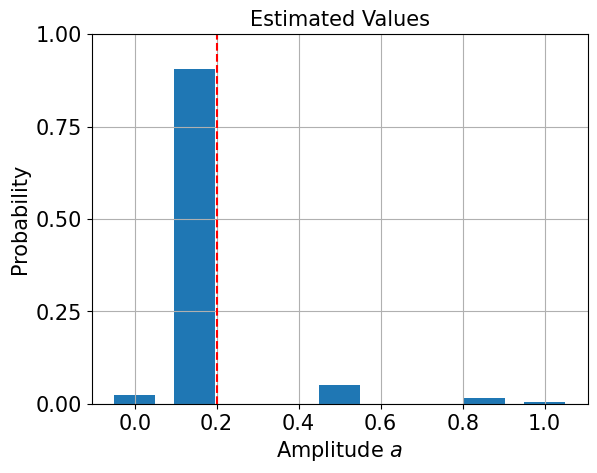

In [5]:
import matplotlib.pyplot as plt

# plot estimated values
gridpoints = list(ae_result.samples.keys())
probabilities = list(ae_result.samples.values())

plt.bar(gridpoints, probabilities, width=0.5 / len(probabilities))
plt.axvline(p, color="r", ls="--")
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title("Estimated Values", size=15)
plt.ylabel("Probability", size=15)
plt.xlabel(r"Amplitude $a$", size=15)
plt.ylim((0, 1))
plt.grid()
plt.show()

In [6]:
#To improve the estimate we can interpolate the measurement probabilities and compute the maximum likelihood estimator that produces this probability distribution:

print("Interpolated MLE estimator:", ae_result.mle)

Interpolated MLE estimator: 0.19999999497921261


In [13]:
ae_circuit = ae.construct_circuit(problem)
ae_circuit.decompose().draw()

┌───┐                                                   »
eval_0: ──────┤ H ├─────────────■─────────────────────────────────────»
              ├───┤             │                                     »
eval_1: ──────┤ H ├─────────────┼──────────────■──────────────────────»
              ├───┤             │              │                      »
eval_2: ──────┤ H ├─────────────┼──────────────┼──────────────■───────»
        ┌─────┴───┴─────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐»
     q: ┤ R(0.9273,π/2) ├┤ circuit-328 ├┤ circuit-337 ├┤ circuit-346 ├»
        └───────────────┘└─────────────┘└─────────────┘└─────────────┘»
«        ┌──────────┐
«eval_0: ┤2         ├
«        │          │
«eval_1: ┤1 IQFT_dg ├
«        │          │
«eval_2: ┤0         ├
«        └──────────┘
«     q: ────────────
«

In [15]:
from qiskit import transpile


basis_gates = ["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]
transpile(ae_circuit, basis_gates=basis_gates, optimization_level=2).draw()

┌───┐     ┌──────┐                                               »
eval_0: ────┤ H ├─────┤ P(0) ├──■────────────────────────────────────────────»
            ├───┤     ├──────┤  │                                            »
eval_1: ────┤ H ├─────┤ P(0) ├──┼────────────────────────────────────────────»
            ├───┤     ├──────┤  │                                            »
eval_2: ────┤ H ├─────┤ P(0) ├──┼────────────────────────────────────────────»
        ┌───┴───┴────┐└──────┘┌─┴─┐┌─────┐┌───┐┌─────┐┌─────────────────────┐»
     q: ┤ Ry(0.9273) ├────────┤ X ├┤ Sdg ├┤ H ├┤ Sdg ├┤ P(2.21429743558818) ├»
        └────────────┘        └───┘└─────┘└───┘└─────┘└─────────────────────┘»
«                                                                    »
«eval_0: ──────────────────────────────■─────────────────────────────»
«                                      │                             »
«eval_1: ──────────────────────────────┼─────────────────────────────»
«                                      │                             »
«eval_2: ──────────────────────────────┼─────────────────────────────»
«        ┌─────┐┌───┐┌─────┐┌───────┐┌─┴─┐┌──────┐┌─────┐┌───┐┌─────┐»
«     q: ┤ Sdg ├┤ H ├┤ Sdg ├┤ P(3π) ├┤ X ├┤ P(0) ├┤ Sdg ├┤ H ├┤ Sdg ├»
«        └─────┘└───┘└─────┘└───────┘└───┘└──────┘└─────┘└───┘└─────┘»
«                                                                            »
«eval_0: ────────────────────────────────────────────────────────────────────»
«                                                                            »
«eval_1: ─────────────────────────────────────────────────────■──────────────»
«                                                             │              »
«eval_2: ─────────────────────────────────────────────────────┼──────────────»
«        ┌─────────────────────┐┌─────┐┌───┐┌─────┐┌───────┐┌─┴─┐┌─────┐┌───┐»
«     q: ┤ P(4.06888787159141) ├┤ Sdg ├┤ H ├┤ Sdg ├┤ P(3π) ├┤ X ├┤ Sdg ├┤ H ├»
«        └─────────────────────┘└─────┘└───┘└─────┘└───────┘└───┘└─────┘└───┘»
«                                                                       »
«eval_0: ───────────────────────────────────────────────────────────────»
«                                                                       »
«eval_1: ────────────────────────────────────────────────────────────■──»
«                                                                    │  »
«eval_2: ────────────────────────────────────────────────────────────┼──»
«        ┌─────┐┌─────────────────────┐┌─────┐┌───┐┌─────┐┌───────┐┌─┴─┐»
«     q: ┤ Sdg ├┤ P(1.28700221758657) ├┤ Sdg ├┤ H ├┤ Sdg ├┤ P(3π) ├┤ X ├»
«        └─────┘└─────────────────────┘└─────┘└───┘└─────┘└───────┘└───┘»
«                                                                             »
«eval_0: ─────────────────────────────────────────────────────────────────────»
«                                                                             »
«eval_1: ─────────────────────────────────────────────────────────────────────»
«                                                                             »
«eval_2: ─────────────────────────────────────────────────────────────────────»
«        ┌──────┐┌─────┐┌───┐┌─────┐┌─────────────────────┐┌─────┐┌───┐┌─────┐»
«     q: ┤ P(0) ├┤ Sdg ├┤ H ├┤ Sdg ├┤ P(4.99618308959302) ├┤ Sdg ├┤ H ├┤ Sdg ├»
«        └──────┘└─────┘└───┘└─────┘└─────────────────────┘└─────┘└───┘└─────┘»
«                                                                              »
«eval_0: ──────────────────────────────────────────────────────────────────────»
«                                                                              »
«eval_1: ──────────────────────────────────────────────────────────────────────»
«                                                                              »
«eval_2: ───────────■──────────────────────────────────────────────────────────»
«        ┌───────┐┌─┴─┐┌─────┐┌───┐┌─────┐┌───────────────────────┐┌─────┐┌───┐

In [16]:
#Iterative Amplitude Estimation
from qiskit.algorithms import IterativeAmplitudeEstimation

iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    sampler=sampler,
)
iae_result = iae.estimate(problem)

print("Estimate:", iae_result.estimation)

Estimate: 0.2


In [18]:
iae_circuit = iae.construct_circuit(problem, k=3)
iae_circuit.draw()

┌────────────┐┌────────────┐
q: ┤ Ry(0.9273) ├┤ Ry(5.5638) ├
   └────────────┘└────────────┘

In [20]:
#Maximum Likelihood Amplitude Estimation
from qiskit.algorithms import MaximumLikelihoodAmplitudeEstimation

mlae = MaximumLikelihoodAmplitudeEstimation(
    evaluation_schedule=3,  # log2 of the maximal Grover power
    sampler=sampler,
)
mlae_result = mlae.estimate(problem)

print("Estimate:", mlae_result.estimation)

Estimate: 0.20002237175368104


In [21]:
#Faster Amplitude Estimation
from qiskit.algorithms import FasterAmplitudeEstimation

fae = FasterAmplitudeEstimation(
    delta=0.01,  # target accuracy
    maxiter=3,  # determines the maximal power of the Grover operator
    sampler=sampler,
)
fae_result = fae.estimate(problem)

print("Estimate:", fae_result.estimation)

Estimate: 0.20077949803426834


/Users/pmishra4/opt/anaconda3/envs/QCQML/lib/python3.9/site-packages/qiskit/algorithms/amplitude_estimators/estimation_problem.py:195: UserWarning: Rescaling discards the Grover operator.
  warnings.warn("Rescaling discards the Grover operator.")
